<a href="https://colab.research.google.com/github/Koar-create/Yang-Repository-CS/blob/main/W1D2T3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **W1D2T3.ipynb**

Author: Zhixian Yang

Email: yangzhx28@mail2.sysu.edu.cn

GitHub: https://github.com/koar-create

Date created: July 13th, 2023

Last modified: July 13th, 2023

<br><br>

---

<br><br>

## **Description**
This document is a Jupyter Notebook designed for an exercise derived from the "Computational Tools for Climate Science 2023" course offered by Climatematch Academy. The code presented here comprises a combination of materials provided in the course and code obtained from online sources.

**_<font color='E00000' size=6>install dependencies, import related packages</font>_**

---

**_<font face='Times New Roman' size=4 >no comments</font>_**

In [1]:
!pip install cftime
!pip install xarray
!pip install cartopy

!pip install cdsapi
!pip install pythia_datasets

In [2]:
import time, cftime
import os, sys, warnings
from datetime import datetime, timedelta
import numpy as np, pandas as pd, xarray as xr
import matplotlib as mpl, matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)

import pooch
import cdsapi
from pythia_datasets import DATASETS

In [3]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!apt-get install python3-cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
import cartopy.io.shapereader as shapereader

**_<font color='E00000' size=7>part 1</font>_**

---

**_<font face='Times New Roman' size=4 >downloading data from ECMWF using cdsapi package</font>_**

In [4]:
!echo "url: https://cds.climate.copernicus.eu/api/v2" > $HOME/.cdsapirc
!echo "key: *erased*" >> $HOME/.cdsapirc
!cat $HOME/.cdsapirc

In [5]:
mode     = 'SH'
filename = f"2016-{mode}-JanJul.nc"
extra_flag = "no"
line1 = {'LH':             'land' , 'LM':            'land-monthly-means',
         'SH':   'single-levels'  , 'SM':   'single-levels-monthly-means',
         'PH': 'pressure-levels'  , 'PM': 'pressure-levels-monthly-means', }
product_type = {'H': 'reanalysis',
                'M': 'monthly_averaged_reanalysis', }
u = {'L': '10m_',
     'S': '10m_',
     'P':     '', }
v = {'L': '10m_',
     'S': '10m_',
     'P':     '', }
T = {'L':        'skin_',
     'S': 'sea_surface_',
     'P':             '', }
precip = {'L': 'total_precipitation',
          'S': 'total_precipitation',
          'P':                    '', }
'''
↑ don't change
↓ customize
'''
pressure_level = {'pressure_level': ['500', '1000']}
# dict_day = {'day': [f"{i:02}" for i in range(1, 31+1, 1)]}
dict_day = {'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
                    '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                    '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', ], }

extra_variables = {"yes": {'L': ['2m_dewpoint_temperature', '2m_temperature', 'surface_pressure', ],
                           'S': ['2m_dewpoint_temperature', '2m_temperature', 'surface_pressure', 'mean_sea_level_pressure', ],
                           'P': ['divergence', 'fraction_of_cloud_cover', 'geopotential', 'ozone_mass_mixing_ratio', 'potential_vorticity', 'relative_humidity', 'specific_cloud_ice_water_content', 'specific_cloud_liquid_water_content', 'specific_humidity', 'specific_rain_water_content', 'specific_snow_water_content', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity', 'vorticity', ], },
                   "no": {'L': [], 'S': [], 'P': [], }}

In [6]:
retrieve_dict = {
        'product_type': product_type[mode[-1]],
        'variable': [
            u[mode[0]]+'u_component_of_wind',
            v[mode[0]]+'v_component_of_wind',
            T[mode[0]]+'temperature',
            precip[mode[0]],
        ] + extra_variables[extra_flag][mode[0]],
        'year': [
            '2016',
        ],
        'month': [
            '01', '07',
        ],
        'time': [
            '00:00', '12:00'
        ],
        'format': 'netcdf',
        'area': [
            90, -180, -90, 180,
        ],
    }
if mode == 'LH':
   retrieve_dict = {key: value for key, value in retrieve_dict.items() if key not in {'product_type': []}}
if mode[0] == 'P':
  retrieve_dict.update(pressure_level)
if mode[1] == 'H':
  retrieve_dict.update(dict_day)

if not os.path.exists('2016-SH-JanJul.nc'):
  c = cdsapi.Client()
  c.retrieve(
      'reanalysis-era5-'+line1[mode],
      retrieve_dict,
      filename)

**_<font color='E00000' size=7>part 2</font>_**

---

**_<font face='Times New Roman' size=4 >no comment...</font>_**

In [ ]:
ds = xr.open_dataset(filename)
ds

In [ ]:
ds = xr.merge([ds, xr.Dataset(data_vars={'V10': np.sqrt(ds.u10**2 + ds.v10**2)})])
ds

In [ ]:
region_ds = ds.sel(time=(ds.time.dt.month==1), latitude=slice(50, 10), longitude=slice(100, 150))
region_ds

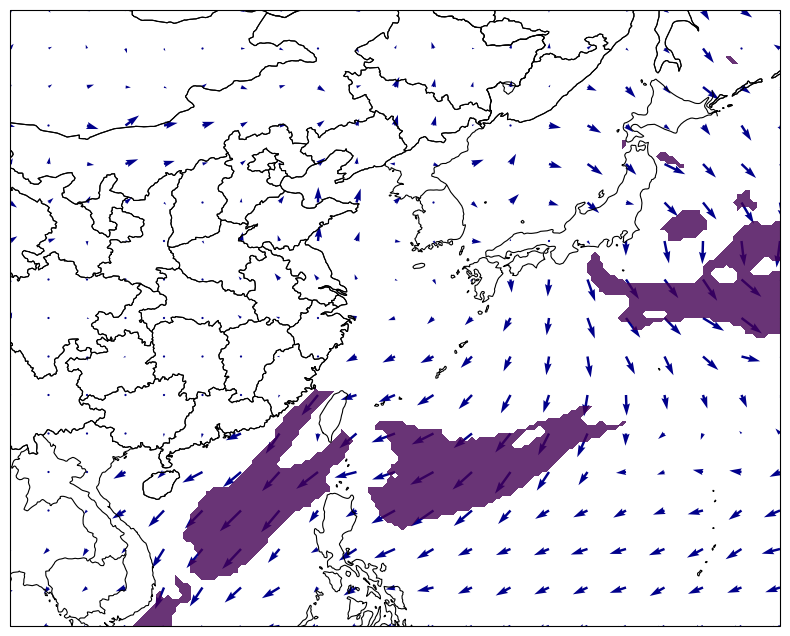

In [10]:
proj = ccrs.PlateCarree()
# proj = ccrs.Robinson()
# proj = ccrs.LambertConformal(central_longitude=125, central_latitude=30, standard_parallels=(30, 60))
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': proj})
skip = 10
ax.quiver(region_ds.longitude.data[::skip], region_ds.latitude.data[::skip],
          region_ds.u10.data[0, ::skip, ::skip], region_ds.v10.data[0, ::skip, ::skip],
          units='inches', scale=50, color='darkblue', transform=ccrs.PlateCarree())
ax.contourf(region_ds.longitude, region_ds.latitude, np.where(region_ds.V10[0, :, :].data<=12., np.nan, region_ds.V10[0, :, :].data),
            cmap='viridis_r', levels=np.linspace(0, 10, 13), transform=ccrs.PlateCarree(), alpha=0.8, extend='both')
ax.add_feature(cfeature.BORDERS,   linewidth=0.8)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.STATES,    linewidth=0.8)

**_<font color='E00000' size=7>part 2</font>_**

---

**_<font face='Times New Roman' size=4 >no comment...</font>_**

In [ ]:
fname = 'ERA5_surface_winds_mm.nc'
if not os.path.exists(fname):
    url = "https://osf.io/3q4vs/download"
    fname = pooch.retrieve(url, known_hash=None, fname=fname)

ERA5_mm=xr.open_dataset(fname).sel(time=slice('1980', '2010'))
ERA5_mm

In [ ]:
ERA5_ANN = ERA5_mm.mean('time')
ERA5_ANN

In [ ]:
region_ERA5_ANN = ERA5_ANN.sel(latitude=slice(40, 30), longitude=slice(135, 145))
region_ERA5_ANN

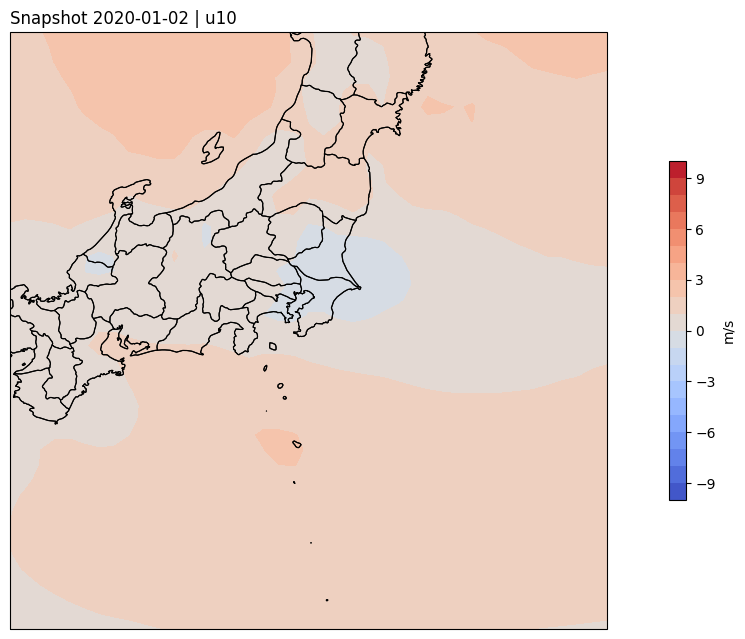

In [38]:
date = '2020-01-02'
colorlevels = np.arange(-25, 27, 2)
colorlevels_clim = np.arange(-10, 11, 1)
var = 'u10'
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': proj})
ax.set_title('Snapshot ' + date + ' | ' + var , loc='left')
dataplot = ax.contourf(region_ERA5_ANN.longitude, region_ERA5_ANN.latitude, region_ERA5_ANN[var],
                       levels = colorlevels_clim, transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
ax.add_feature(cfeature.BORDERS,   linewidth=0.8)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.STATES,    linewidth=0.8)
# region_ERA5_ANN.u10.plot.contourf(levels=12)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
# plt.show()